In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from scipy.optimize import curve_fit
import os
import numpy as np
import glob

In [39]:
from scipy import stats

def linearRegression(df):
    x = df[df.DiscoveryTime.notnull()].trialNum.values
    y = df[df.DiscoveryTime.notnull()].DiscoveryTime.values

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    return(slope, intercept, r_value, p_value, std_err)

In [27]:
# Define exponential function func,  
# where a = alpha, b = Tau, c = y intercept

def fit_to_exponential(x, a, b, c):
     return a * np.exp(-(x / b)) + c

# Individual floral shape

In [4]:
direc = './dataFolders/Output/Step5_FilesWith_TrueTrialAnd_ProboscisDetect/'

outpath = './dataFolders/Output/Step6_FloralTypeConsolidatedData_AndFitParameters/'
outpath_fig = './dataFolders/Output/Figures/LinearRegression_toFindFitParameters/'

Save the all shape specific files as a single file

In [6]:
floralShape = ['c-1_', 'c-2_', 'c-3_', 'c-10_']


for floralShape in floralShape:
    
    Shape_specific_file = glob.glob(direc + floralShape + '*Raw*.csv')
       
    # get the data together and save as single dataset

    df1=[]
    df2=[]
    df3=[]
    df4=[]
    df5=[]
    df6=[]

    ctr = 0
    for fpath in Shape_specific_file:
        df = pd.read_csv(fpath)
        DiscoveryTime = df['DiscoveryTime']
        trialNum= df.index
        fname = os.path.basename(fpath)[:-30]
        names = [fname]*len(trialNum)
        mothIn = df['MothIN']
        mothOut = df['MothOut']
        Proboscis = df['ProboscisDetect']

        df1.extend(DiscoveryTime)
        df2.extend(trialNum)
        df3.extend(names)
        df4.extend(mothIn)
        df5.extend(mothOut)
        df6.extend(Proboscis)
        ctr+=1
        print(ctr)

    new_df = (pd.DataFrame({'MothIn': df4, 'MothOut': df5, 'ProboscisDetect': df6,
                            'DiscoveryTime': df1, 'trialNum': df2, 'name' : df3}))
    print(floralShape + "has a total of" + str(ctr) + "moths")
    new_df.to_csv(outpath + floralShape + "Alltrials.csv")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
c-1_has a total of20moths
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
c-2_has a total of21moths
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
c-3_has a total of24moths
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
c-10_has a total of22moths


Fit to curve and plot

In [7]:
import glob

dFrame = pd.DataFrame()

file = glob.glob(outpath + '*.csv')

for file in file:
    df = pd.read_csv(file)
    dFrame = dFrame.append(df)
dFrame.to_csv(outpath  + "AllMoths_AllTrials.csv")

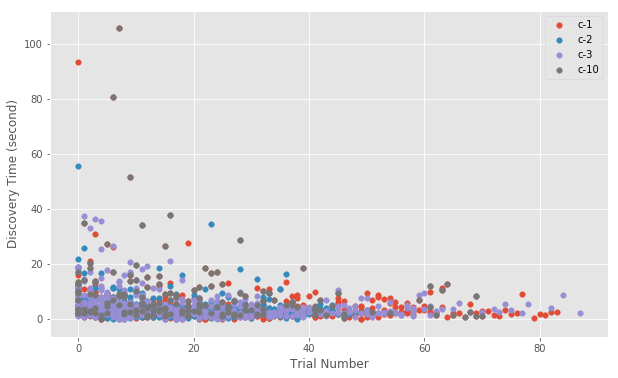

In [23]:
shapes = ['c-1', 'c-2','c-3', 'c-10']
fig = plt.subplots(figsize = (10,6))
for shape in shapes:
    x = dFrame[dFrame.name.str.contains(shape)].trialNum
    y = dFrame[dFrame.name.str.contains(shape)].DiscoveryTime
    plt.scatter(x, y/100, marker = 'o', s = 30, label = shape)
    plt.legend()
    plt.ylabel('Discovery Time (second)')
    plt.xlabel('Trial Number')
#     plt.ylim(-1,50)

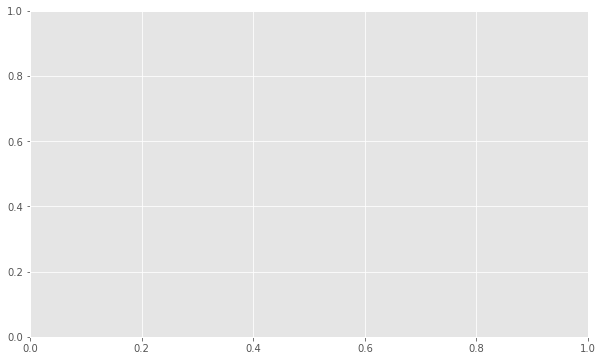

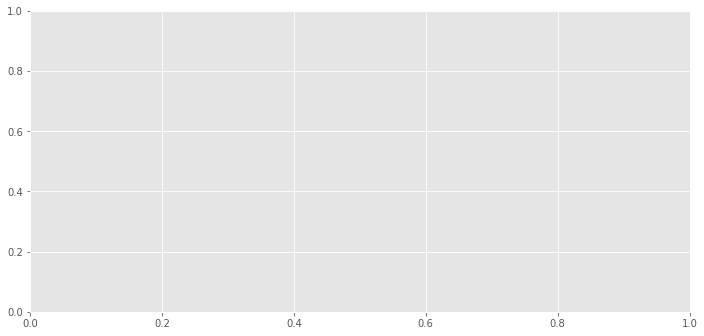

In [46]:
# do the fit for three different y0 - computed across different lengths of the saturation - curve
shapes = ['c-1', 'c-2','c-3', 'c-10']
fig1, ax0 = plt.subplots(figsize = (10,6))
fig2, ax1 = plt.subplots(figsize = (10,6))

for floralShape in shapes:
    
    file  = glob.glob(outpath + floralShape + '_Alltrials.csv')
    new_df = pd.read_csv(file[0])
    
    xdata = new_df.trialNum.values
    ydata = new_df.DiscoveryTime.values
    
    xdata_notnan = new_df[new_df.DiscoveryTime.notnull()].trialNum.values
    ydata_notnan = new_df[new_df.DiscoveryTime.notnull()].DiscoveryTime.values
    numMoth = len(new_df.name.unique())
    
    length_to_estimate_y0 = [2, 4, 8]

    # initialize all the variables you want to save
    slope = []
    std_err = []
    p_value = []
    r_value = []
    y_intercept = []
    average_firstTrial = []
    alpha = []
    tau= []
    covariance = []

    for length in length_to_estimate_y0:
        totalTrial = max(new_df.trialNum)
        part_of_df = new_df[new_df.trialNum >= (totalTrial * (1-1/length))]

        m, y0, r_val, p_val, se = linearRegression(part_of_df)

        mean_y0 = part_of_df.DiscoveryTime.mean()
        mean_a0andy0 = new_df[new_df.trialNum==0].DiscoveryTime.mean()
        a0 = mean_a0andy0 - mean_y0

        # plot the regression line
        x = part_of_df.trialNum
        y = part_of_df.DiscoveryTime
        ax0.plot(x,y*1/100, 'ob', markersize=5, alpha=.5, label = 'Raw data')
        test_x = range(min(x)-5, max(x)+5)
        ax0.plot(test_x, (m*test_x + y0)*1/100, label = 'Fitted line')
        ax0.fill_between(test_x, ((m-se)*test_x + y0)*1/100, ((m+se)*test_x + y0)*1/100, alpha=0.2)
        ax0.set_title(floralShape + '_1/' + str(length) + '_lengthData')
        ax0.legend()
        fig1.savefig(outpath_fig + floralShape + '_1-' + str(length) + '_LinearRegression.svg')
        ax0.cla()

        slope.append(m/100)
        std_err.append(se/100)
        p_value.append(p_val)
        r_value.append(r_val)
        y_intercept.append(mean_y0/100)
        average_firstTrial.append(mean_a0andy0/100)
        alpha.append(a0/100)
        
        
        popt,pcov = curve_fit(lambda x, b: fit_to_exponential(x, a0, b, mean_y0), xdata_notnan, ydata_notnan)
        tau.append(popt[0]/100)
        covariance.append(pcov.flatten()[0])

        # plot the final curve fit
        max_trial=max(xdata)
        ax1.plot(xdata, ydata*1/100, 'or', markersize=7, alpha=.5, label = 'Raw data')
        ax1.plot(range(0,max_trial), fit_to_exponential(range(0,max_trial), a0, *popt, mean_y0)*1/100, 
                 'g--', linewidth=2, 
                 label = 'fit: alpha= %5.3f , Tau= %5.3f, y0= %5.3f' %(a0/100, popt/100, mean_y0/100))

        ax1.set_title(floralShape + '_1-' + str(length) + '_length', y=1.2)
        ax1.set_xlabel('Trial number')
        ax1.set_ylabel('Exploration Time (second)')
        leg = plt.legend()
        leg.get_frame().set_linewidth(1.5)
        ax1.legend(bbox_to_anchor=(0., 1.05, 1., .102), loc=3, mode="expand", borderaxespad=0.)
        ax1.set_xlim([-5,90])
        ax1.set_ylim([-5,55])
        ax1.text(60, 40, 'N= ' + str(numMoth))
        fig2.tight_layout()
        fig2.savefig(outpath_fig + 'LearningCurve_' + floralShape + '_1-' + str(length) + '_length.svg')
        ax1.cla()

    all_param_df = pd.DataFrame({'slope':slope, 'std_err':std_err,
                                 'p_value':p_value, 'r_value':r_value,
                                 'y_intercept':y_intercept,
                                 'average_firstTrial':average_firstTrial,
                                 'alpha':alpha,'tau':tau,
                                 'covariance':covariance}, 
                                index = ['one-half', 'last fourth', 'last eight'])
    all_param_df.to_csv(outpath + floralShape + '_FittedParameters.csv')

In [41]:
all_param_df

,slope,std_err,p_value,r_value,y_intercept,average_firstTrial,alpha,tau,covariance
one-half,-0.018639,0.067857,0.785582,-0.051839,4.948667,8.788889,3.840222,0.509870,2532.747152
last fourth,-0.188577,0.288511,0.526783,-0.193355,5.126923,8.788889,3.661966,0.486288,2452.940447
last eight,-1.147520,0.627691,0.117287,-0.598123,4.940000,8.788889,3.848889,0.511448,2523.742381
